### Qwen Embed 測試

輸入meilisearch 測試檢索準確率

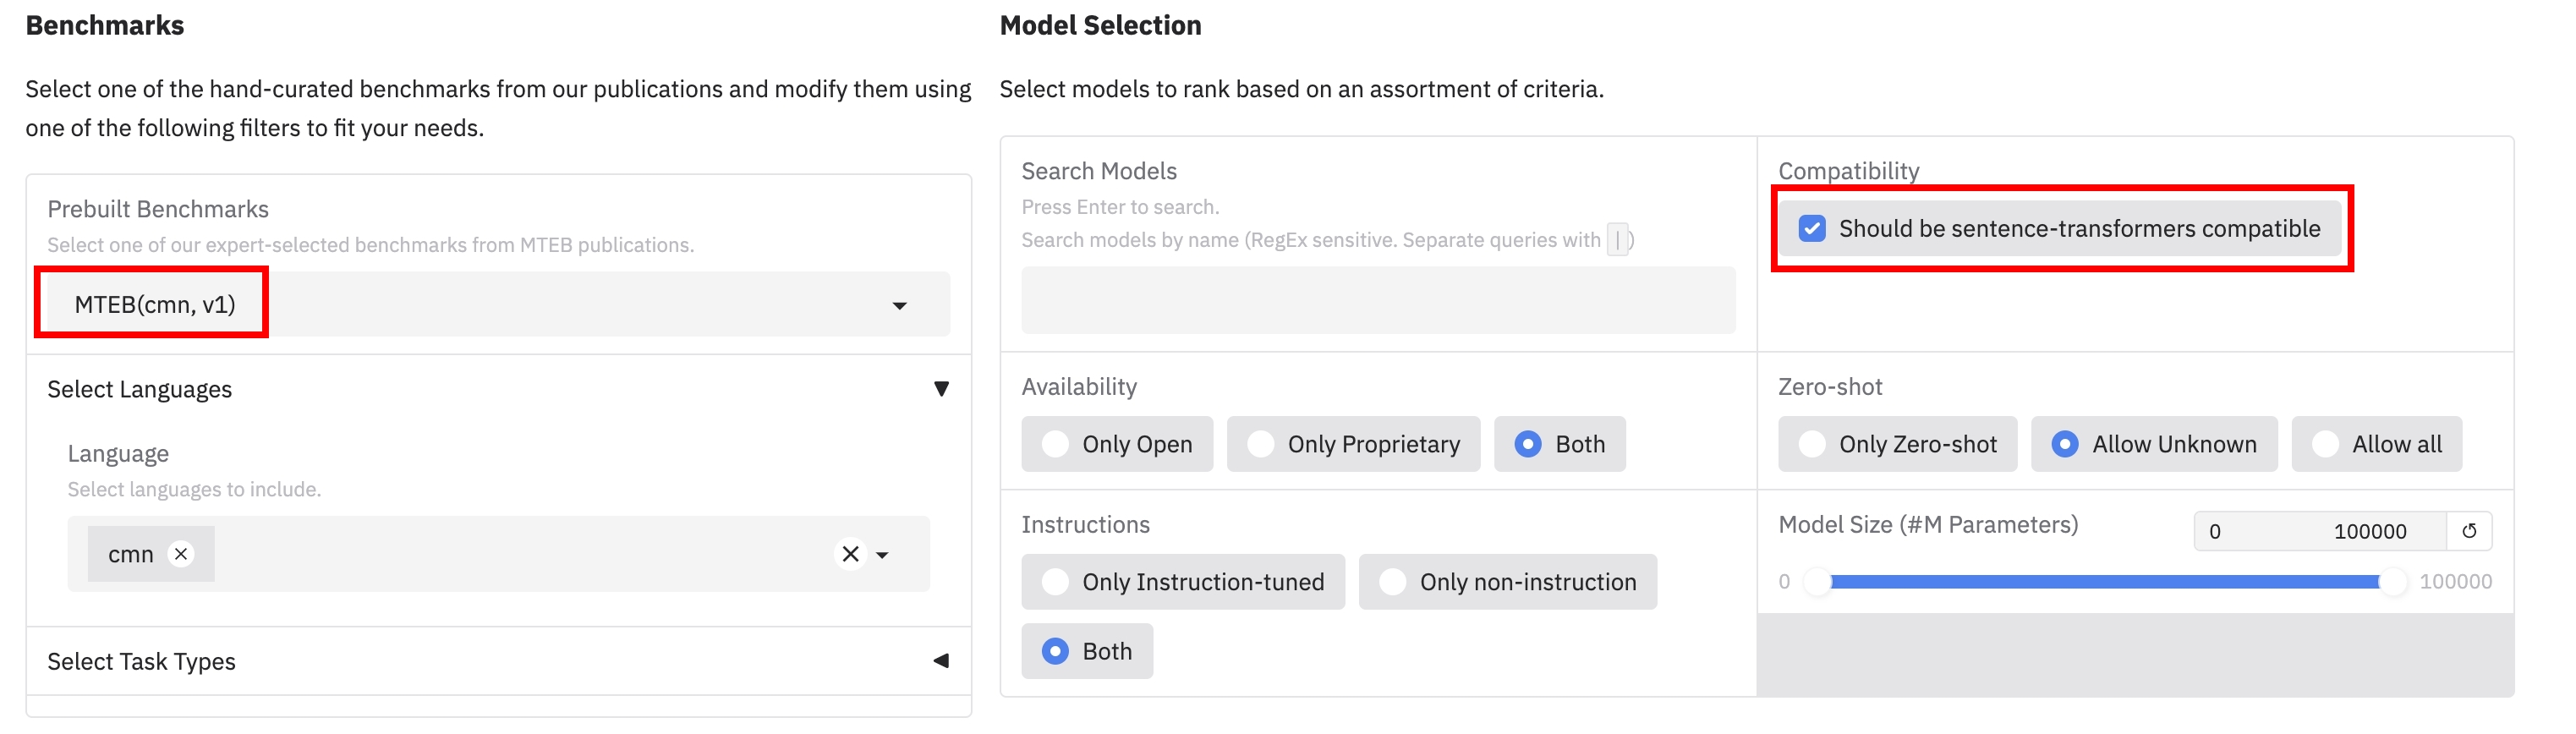

In [1]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

# 檢查是否有 MPS (Mac GPU) 裝置，否則使用 CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"使用裝置：{device}")

# 1. 定義載入模型與 tokenizer 的函式，並移至指定裝置
def load_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.to(device)
    model.eval()  # 設定模型為評估模式
    return tokenizer, model

# 2. 定義計算句子 embedding 的函式（採用 mean pooling）
def compute_embeddings(sentences, tokenizer, model):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    token_embeddings = model_output.last_hidden_state  # (batch_size, seq_len, hidden_size)
    attention_mask = encoded_input['attention_mask']
    # 擴展 attention mask
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    # 進行平均池化
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
    embeddings = sum_embeddings / sum_mask
    return embeddings.cpu()  # 返回 CPU 上的 tensor 以便後續計算

# 3. 準備測試資料（繁體中文）
corpus = [
    "今天天氣很好，適合外出散步。",
    "這部電影非常精彩，值得推薦。",
    "美食街的餐廳味道不錯，但價格偏高。",
    "台北的夜市熱鬧非凡，吸引眾多遊客。",
    "科技產品更新迅速，市場競爭激烈。"
]

queries = [
    "我想找個適合散步的地方",
    "推薦一部好看的電影",
    "哪裡可以吃到美味的食物？"
]

# 4. 測試模型清單
models = [
    "shibing624/text2vec-base-chinese",
    "TencentBAC/Conan-embedding-v1",
    "GanymedeNil/text2vec-large-chinese",
    "Alibaba-NLP/gte-Qwen2-7B-instruct"
]

# 5. 對每個模型進行測試
for model_name in models:
    print(f"\n正在使用模型：{model_name}")
    tokenizer, model = load_model_and_tokenizer(model_name)
    
    # 生成語料與查詢的 embedding
    corpus_embeddings = compute_embeddings(corpus, tokenizer, model)
    query_embeddings = compute_embeddings(queries, tokenizer, model)
    
    # 計算查詢與語料間的餘弦相似度
    similarities = cosine_similarity(query_embeddings.numpy(), corpus_embeddings.numpy())
    
    # 依據相似度排序，列出每個查詢最相關的三筆結果
    for i, query in enumerate(queries):
        print(f"\n查詢：{query}")
        top_indices = np.argsort(-similarities[i])[:3]  # 取前 3 筆
        for idx in top_indices:
            print(f"  結果：{corpus[idx]} (相似度：{similarities[i][idx]:.4f})")
    print("=" * 50)


/Users/Johnny/miniconda3/envs/jenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用裝置：mps

正在使用模型：shibing624/text2vec-base-chinese


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



查詢：我想找個適合散步的地方
  結果：今天天氣很好，適合外出散步。 (相似度：0.7574)
  結果：美食街的餐廳味道不錯，但價格偏高。 (相似度：0.3520)
  結果：台北的夜市熱鬧非凡，吸引眾多遊客。 (相似度：0.3285)

查詢：推薦一部好看的電影
  結果：這部電影非常精彩，值得推薦。 (相似度：0.7374)
  結果：科技產品更新迅速，市場競爭激烈。 (相似度：0.4159)
  結果：今天天氣很好，適合外出散步。 (相似度：0.3769)

查詢：哪裡可以吃到美味的食物？
  結果：美食街的餐廳味道不錯，但價格偏高。 (相似度：0.6565)
  結果：台北的夜市熱鬧非凡，吸引眾多遊客。 (相似度：0.4319)
  結果：這部電影非常精彩，值得推薦。 (相似度：0.3272)

正在使用模型：TencentBAC/Conan-embedding-v1


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



查詢：我想找個適合散步的地方
  結果：今天天氣很好，適合外出散步。 (相似度：0.7445)
  結果：美食街的餐廳味道不錯，但價格偏高。 (相似度：0.5197)
  結果：這部電影非常精彩，值得推薦。 (相似度：0.5027)

查詢：推薦一部好看的電影
  結果：這部電影非常精彩，值得推薦。 (相似度：0.8083)
  結果：台北的夜市熱鬧非凡，吸引眾多遊客。 (相似度：0.5421)
  結果：今天天氣很好，適合外出散步。 (相似度：0.5153)

查詢：哪裡可以吃到美味的食物？
  結果：美食街的餐廳味道不錯，但價格偏高。 (相似度：0.6215)
  結果：台北的夜市熱鬧非凡，吸引眾多遊客。 (相似度：0.5519)
  結果：這部電影非常精彩，值得推薦。 (相似度：0.5184)

正在使用模型：GanymedeNil/text2vec-large-chinese


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



查詢：我想找個適合散步的地方
  結果：今天天氣很好，適合外出散步。 (相似度：0.6818)
  結果：美食街的餐廳味道不錯，但價格偏高。 (相似度：0.2178)
  結果：科技產品更新迅速，市場競爭激烈。 (相似度：0.1641)

查詢：推薦一部好看的電影
  結果：這部電影非常精彩，值得推薦。 (相似度：0.7366)
  結果：美食街的餐廳味道不錯，但價格偏高。 (相似度：0.2638)
  結果：科技產品更新迅速，市場競爭激烈。 (相似度：0.2271)

查詢：哪裡可以吃到美味的食物？
  結果：美食街的餐廳味道不錯，但價格偏高。 (相似度：0.4975)
  結果：這部電影非常精彩，值得推薦。 (相似度：0.1830)
  結果：今天天氣很好，適合外出散步。 (相似度：0.1441)

正在使用模型：Alibaba-NLP/gte-Qwen2-7B-instruct


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading checkpoint shards: 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]



查詢：我想找個適合散步的地方
  結果：今天天氣很好，適合外出散步。 (相似度：0.7462)
  結果：這部電影非常精彩，值得推薦。 (相似度：0.6446)
  結果：美食街的餐廳味道不錯，但價格偏高。 (相似度：0.6214)

查詢：推薦一部好看的電影
  結果：這部電影非常精彩，值得推薦。 (相似度：0.8008)
  結果：台北的夜市熱鬧非凡，吸引眾多遊客。 (相似度：0.6177)
  結果：科技產品更新迅速，市場競爭激烈。 (相似度：0.6097)

查詢：哪裡可以吃到美味的食物？
  結果：美食街的餐廳味道不錯，但價格偏高。 (相似度：0.8085)
  結果：台北的夜市熱鬧非凡，吸引眾多遊客。 (相似度：0.7934)
  結果：這部電影非常精彩，值得推薦。 (相似度：0.7551)
